# "Build a model to predict market outcomes"

...

# The purpose of this notebook is to build a binary classifier which will predict if the markets (S&P500 as measured by SPY or VOO; Nasdaq100 as measured by QQQ or QQQM) will close 'Green' (an increase, or with a profit from the previous day's close) or 'Red' (a decrease, or at a loss from the previous day's close). 

#### In principle, such a classifier could likely be applied to any asset or financial security (witholding Options, because that merits its own strategies).

## Application: to inform a real-time strategy at the daily timeframe, which can be used to (manually, for now) enter and exit trades appropriately (based on predictions from the model).

#### Eventually, we will look at automating these strategies likely with Alpaca's Trade API, as we would like to keep returns from this account separate from my other accounts/holdings. This will also ensure we only fund the account in a disciplined manner to avoid the risk of bankrupting myself. The beauty of this being (1) a strategy which would be used to (almost) passively earn income every single day, and (2) this strategy could be employed regardless of market directions so we could make money during bull- as well as bear-markets (short or long term ones).

## Objective: to outperform a DummyClassifier which would simply randomly guess the outcome of the markets on a given day, with equal probability. I.e: we are trying to see if we could do better than a random coin-flip, which is our baseline model to compare with. We would likely also want to compare to so called "Perma-Bulls" and "Perma-Bears" which are almost always bullish and bearish, respectively. A Naive Perma-Bull and -Bear would *always* bet on markets or a security closing green or red, respectively. An intelligent Perma-Bull and Perma-Bear will usually bet on markets closing green or red, but would take into account current macroeconomic factors and technical factors (e.g: does current RSI indicate markets are overbought?), i.e: intelligent bulls and bears will usually be bullish and bearish but on occasion will be bearish or bullish, both respectively.

## Hypothesis: I expect the intelligent perma-bull to perform the best because markets on average tend to move upawards, thus, the perma-bull strategy will reflect reality the best. Following this we may see a tie between the naive perma-bull and naive random guessing. Lastly the intelligent perma-bear and finally the perma-bear will follow in performance. It will be interesting to note whether any of these strategies hold up better or worse historically versus in recent time (i.e: post-COVID markets).

## To start we will manage risk of bankruptcy with Kelly's Criterion, which is a statistical strategy to manae a bankroll and its profit. The other noteworthy risk is that this (and most) strategies may break down at scale (when the amount being bet starts to become "too large"). Thus, this will just be one feather in a cap of many, and we will look at employing various strategies drawing from many disciplines and points of view (classical ML, Technical Analysis, Stochastic Processes and traditional Quant strategies).

### This work is also building off of prior work done roughly in Early 2020.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import sklearn
import yfinance as yf

## Load Data

In [3]:
sp = yf.Ticker('SPY')

In [4]:
sp_df = sp.history(period='max')
sp_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-11-24,466.059998,469.570007,465.190002,469.440002,61858800,0.0,0
2021-11-26,462.339996,463.899994,457.769989,458.970001,112669600,0.0,0
2021-11-29,464.070007,466.559998,461.730011,464.600006,86268800,0.0,0
2021-11-30,462.000000,464.029999,455.299988,455.559998,148559600,0.0,0
2021-12-01,461.640015,464.670013,450.290009,450.500000,132486146,0.0,0


# EDA:

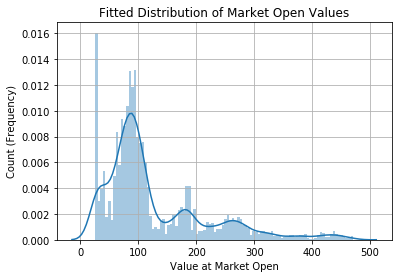

In [5]:
sns.distplot(sp_df.Open, bins=100)
plt.xlabel('Value at Market Open')
plt.ylabel('Count (Frequency)')
plt.title('Fitted Distribution of Market Open Values')
plt.grid()
plt.show()

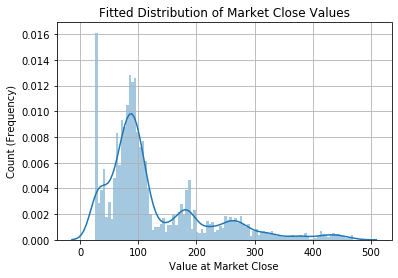

In [6]:
sns.distplot(sp_df.Close, bins=100)
plt.xlabel('Value at Market Close')
plt.ylabel('Count (Frequency)')
plt.title('Fitted Distribution of Market Close Values')
plt.grid()
plt.show()

So if we are going to input market Open's and Close's to our model we should normalize these features to unit mean and variance.

## What do peaks in these distributions correspond to? It seems like it would be bear markets, periods of stagnated growth, or heightened volatility, resulting in more time spent in a certain range which will lead to higher frequency of those values in the distribution.

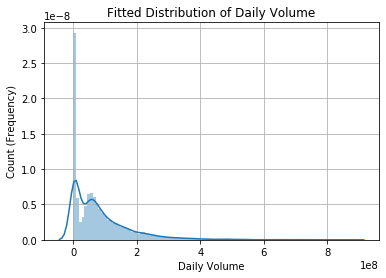

In [7]:
sns.distplot(sp_df.Volume, bins=100)
plt.xlabel('Daily Volume')
plt.ylabel('Count (Frequency)')
plt.title('Fitted Distribution of Daily Volume')
plt.grid()
plt.show()
# TODO? check how to change scale

### What do days with 0 Volume correspond to?

## First off, it's not 0, check the scale. However, we should check what days with min and max volume correspond to and try and determine why or if it has any significance:

In [8]:
sp_df.Volume.min(), sp_df.Volume.max()

(5200, 871026300)

In [9]:
print(
    sp_df.index.unique('Date').min(), 
    sp_df.head(5).Volume.values,
    np.median(sp_df.head(30).Volume.values),
    np.std(sp_df.head(30).Volume.values)
)

sp_df[sp_df.Volume == sp_df.Volume.min()]

1993-01-29 00:00:00 [1003200  480500  201300  529400  531500] 197850.0 238540.53093761657


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1994-09-30,28.247282,28.380974,28.218634,28.218634,5200,0.0,0


In [10]:
np.median(sp_df.head(30).Volume.values) - np.std(sp_df.head(30).Volume.values), 
# we can't have negative volume or shares traded as suggested by the above...
np.median(sp_df.head(30).Volume.values) + np.std(sp_df.head(30).Volume.values)

436390.5309376166

### A little research shows the low volume could be related to the 1994 bond market crisis: https://en.wikipedia.org/wiki/1994_bond_market_crisis

### However, this could be coincidental, characteristic, or an artefact of this dataset given that the date starts in 01/1993, so naturally this implies a lower volume to start: Digging in a little further, we can see above that the median $\pm$ std_dev (197,850 $\pm$ 238,540 or [0, 436,390] shares traded) Volume in the first 30 days of the data (1993-01-29 - 1993-02-28), is still significantly higher than the lowest recorded Volume 1.5 years later on 1994-09-30 which was 5,200 shares traded. This leads me to believe that the lowest-Volume-day must have some significance and is not by chance or is characteristic of the data at that time.

In [11]:
sp_df[sp_df.Volume == sp_df.Volume.max()]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2008-10-10,66.95065,72.491287,64.496719,68.293365,871026300,0.0,0


Max volume could likel be the turn-around of the 2008 crash. TODO: investigate further later, as research from this can inform other trading strategies or general investment intelligence

In [12]:
sp_df.Open.min(), sp_df.Close.min()

(25.40643272372537, 25.40641975402832)

In [13]:
sp_df.Open.max(), sp_df.Close.max()

(470.8900146484375, 469.7300109863281)

### I can tell you from experience that looking into min Open's and Closes's as well as max Open's and Close's is going to be less interesting. All it will reflect is roughly the start and end of the data (markets go up over time, on average--at least historically this is the case).

# Preprocessing

In [14]:
print(sp_df['Stock Splits'].unique())
sp_df.Dividends.unique()

[0]


array([0.   , 0.213, 0.318, 0.286, 0.317, 0.271, 0.305, 0.288, 0.363,
       0.268, 0.316, 0.312, 0.382, 0.285, 0.351, 0.352, 0.367, 0.299,
       0.35 , 0.348, 0.38 , 0.313, 0.359, 0.392, 0.32 , 0.405, 0.372,
       0.371, 0.375, 0.411, 0.346, 0.369, 0.393, 0.331, 0.353, 0.378,
       0.436, 0.354, 0.36 , 0.4  , 0.516, 0.395, 0.414, 0.469, 0.568,
       0.467, 0.488, 0.522, 0.672, 0.519, 0.555, 0.579, 0.793, 0.551,
       0.656, 0.719, 0.775, 0.642, 0.669, 0.691, 0.561, 0.518, 0.508,
       0.59 , 0.48 , 0.531, 0.602, 0.653, 0.553, 0.628, 0.625, 0.77 ,
       0.614, 0.688, 0.779, 1.022, 0.694, 0.839, 0.838, 0.98 , 0.825,
       0.937, 0.939, 1.135, 0.931, 1.03 , 1.033, 1.212, 1.05 , 1.078,
       1.082, 1.329, 1.183, 1.235, 1.351, 1.097, 1.246, 1.323, 1.435,
       1.233, 1.432, 1.384, 1.57 , 1.406, 1.366, 1.339, 1.58 , 1.278,
       1.376, 1.428])

We don't really care about Stock Splits or Dividends, so we can just drop these.

In [15]:
def preprocess(sp_df):
    """
    Preprocess Data for Feature Engineering and Model Input

    Inputs:
    Returns:
    """
    df = sp_df.copy()

    df_clean = df.drop(columns=['Stock Splits','Dividends'])
    return df_clean

In [16]:
print(sp_df.head(1))
sp_df = preprocess(sp_df)
sp_df.head(1)

                Open      High        Low      Close   Volume  Dividends  \
Date                                                                       
1993-01-29  25.73566  25.73566  25.607622  25.717369  1003200        0.0   

            Stock Splits  
Date                      
1993-01-29             0  


,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,25.73566,25.73566,25.607622,25.717369,1003200


# Feature Engineering:

In [17]:
sp_df['day_change'] = sp_df.Close - sp_df.Open
sp_df.head()

,Open,High,Low,Close,Volume,day_change
Date,,,,,,
1993-01-29,25.735660,25.735660,25.607622,25.717369,1003200,-0.018291
1993-02-01,25.735667,25.900288,25.735667,25.900288,480500,0.164620
1993-02-02,25.881988,25.973444,25.827114,25.955153,201300,0.073165
1993-02-03,25.991749,26.247825,25.973458,26.229534,529400,0.237785
1993-02-04,26.320984,26.394149,26.028326,26.339275,531500,0.018291


In [18]:
sp_df['close_label'] = sp_df.day_change.apply(lambda x: 1 if x > 0 else 0) # 'Green' == 1
sp_df.tail()

,Open,High,Low,Close,Volume,day_change,close_label
Date,,,,,,,
2021-11-24,466.059998,469.570007,465.190002,469.440002,61858800,3.380005,1
2021-11-26,462.339996,463.899994,457.769989,458.970001,112669600,-3.369995,0
2021-11-29,464.070007,466.559998,461.730011,464.600006,86268800,0.529999,1
2021-11-30,462.000000,464.029999,455.299988,455.559998,148559600,-6.440002,0
2021-12-01,461.640015,464.670013,450.290009,450.500000,132486146,-11.140015,0


### close_label is our target. Given a sequence of days x1,...,xN we want to predict close_label on day xN+1.

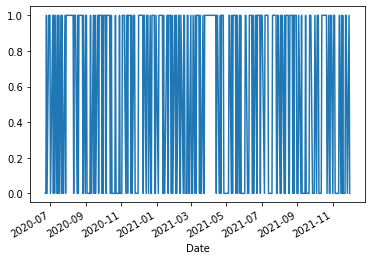

In [19]:
sp_df.close_label[-365:-1].plot()
plt.show()

We can see periods of low volatility in our target variable may preclude or follow periods of high volatility. This is a hypothesis which we should test. Ideally, this is something our model would infer if true, but I would also like to know this for general knowledge.

In [20]:
sp_df['max_magnitude_change'] = np.abs(sp_df.High - sp_df.Low) # we don't know which came first
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change
Date,,,,,,,,
1993-01-29,25.735660,25.735660,25.607622,25.717369,1003200,-0.018291,0,0.128038
1993-02-01,25.735667,25.900288,25.735667,25.900288,480500,0.164620,1,0.164620
1993-02-02,25.881988,25.973444,25.827114,25.955153,201300,0.073165,1,0.146329
1993-02-03,25.991749,26.247825,25.973458,26.229534,529400,0.237785,1,0.274368
1993-02-04,26.320984,26.394149,26.028326,26.339275,531500,0.018291,1,0.365823


In [21]:
# the high or low will always come after the Open, the earliest they can come is at Open
sp_df['largest_day_gain'] = np.max([sp_df.High - sp_df.Open, sp_df.Close - sp_df.Low], axis=0)
sp_df['largest_day_loss'] = np.min([sp_df.Low - sp_df.Open, sp_df.Close - sp_df.High], axis=0)
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss
Date,,,,,,,,,,
1993-01-29,25.735660,25.735660,25.607622,25.717369,1003200,-0.018291,0,0.128038,0.109747,-0.128038
1993-02-01,25.735667,25.900288,25.735667,25.900288,480500,0.164620,1,0.164620,0.164620,0.000000
1993-02-02,25.881988,25.973444,25.827114,25.955153,201300,0.073165,1,0.146329,0.128038,-0.054873
1993-02-03,25.991749,26.247825,25.973458,26.229534,529400,0.237785,1,0.274368,0.256076,-0.018291
1993-02-04,26.320984,26.394149,26.028326,26.339275,531500,0.018291,1,0.365823,0.310950,-0.292659


In [22]:
sp_df.tail()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss
Date,,,,,,,,,,
2021-11-24,466.059998,469.570007,465.190002,469.440002,61858800,3.380005,1,4.380005,4.250000,-0.869995
2021-11-26,462.339996,463.899994,457.769989,458.970001,112669600,-3.369995,0,6.130005,1.559998,-4.929993
2021-11-29,464.070007,466.559998,461.730011,464.600006,86268800,0.529999,1,4.829987,2.869995,-2.339996
2021-11-30,462.000000,464.029999,455.299988,455.559998,148559600,-6.440002,0,8.730011,2.029999,-8.470001
2021-12-01,461.640015,464.670013,450.290009,450.500000,132486146,-11.140015,0,14.380005,3.029999,-14.170013


In [23]:
sp_df['day_sd'] = np.std([sp_df.Open, sp_df.High, sp_df.Low, sp_df.Close], axis=0)
sp_df['day_mean'] = np.mean([sp_df.Open, sp_df.High, sp_df.Low, sp_df.Close], axis=0)
sp_df['day_median'] = np.median([sp_df.Low, sp_df.High], axis=0)
sp_df.tail()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,day_median
Date,,,,,,,,,,,,,
2021-11-24,466.059998,469.570007,465.190002,469.440002,61858800,3.380005,1,4.380005,4.250000,-0.869995,1.964773,467.565002,467.380005
2021-11-26,462.339996,463.899994,457.769989,458.970001,112669600,-3.369995,0,6.130005,1.559998,-4.929993,2.474839,460.744995,460.834991
2021-11-29,464.070007,466.559998,461.730011,464.600006,86268800,0.529999,1,4.829987,2.869995,-2.339996,1.720533,464.240005,464.145004
2021-11-30,462.000000,464.029999,455.299988,455.559998,148559600,-6.440002,0,8.730011,2.029999,-8.470001,3.860912,459.222496,459.664993
2021-12-01,461.640015,464.670013,450.290009,450.500000,132486146,-11.140015,0,14.380005,3.029999,-14.170013,6.469744,456.775009,457.480011


In [24]:
def generate_features(sp_df):
    """
    Derive a more robust set of features from the given data

    Inputs:
    Returns:
    """
    df = sp_df.copy()

    # compute the day change, the observed difference between the Close and Open
    df['day_change'] = df.Close - df.Open

    # compute the class labels or outcomes of interest ("Green" == 1)
    df['close_label'] = df.day_change.apply(lambda x: 1 if x > 0 else 0)
    # close_label is our target. Given a sequence of days x1,...,xN we want to predict close_label on day xN+1.
    
    # compute the magnitude of change observed between the max and min value
    ## observed on a given day
    df['max_magnitude_change'] = np.abs(df.High - df.Low) 
    # we take the absolute value, because we don't know which value came first..

    # compute largest day gain and loss observed
    df['largest_day_gain'] = np.max([df.High - df.Open, df.Close - df.Low], axis=0)
    df['largest_day_loss'] = np.min([df.Low - df.Open, df.Close - df.High], axis=0)
    # the high or low will always come after the Open, the earliest they can come is at Open

    # compute descriptive statistics of the values for the day that we DO have
    df['day_sd'] = np.std([df.Open, df.High, df.Low, df.Close], axis=0)
    df['day_mean'] = np.mean([df.Open, df.High, df.Low, df.Close], axis=0)
    df['day_median'] = np.median([df.Low, df.High], axis=0)
    # TODO: need to get intraday values/data for the entire day

    return df

In [25]:
%%time
res_df = generate_features(sp_df)
res_df.tail()

CPU times: user 35.5 ms, sys: 8.15 ms, total: 43.7 ms
Wall time: 38.9 ms


,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,day_median
Date,,,,,,,,,,,,,
2021-11-24,466.059998,469.570007,465.190002,469.440002,61858800,3.380005,1,4.380005,4.250000,-0.869995,1.964773,467.565002,467.380005
2021-11-26,462.339996,463.899994,457.769989,458.970001,112669600,-3.369995,0,6.130005,1.559998,-4.929993,2.474839,460.744995,460.834991
2021-11-29,464.070007,466.559998,461.730011,464.600006,86268800,0.529999,1,4.829987,2.869995,-2.339996,1.720533,464.240005,464.145004
2021-11-30,462.000000,464.029999,455.299988,455.559998,148559600,-6.440002,0,8.730011,2.029999,-8.470001,3.860912,459.222496,459.664993
2021-12-01,461.640015,464.670013,450.290009,450.500000,132486146,-11.140015,0,14.380005,3.029999,-14.170013,6.469744,456.775009,457.480011


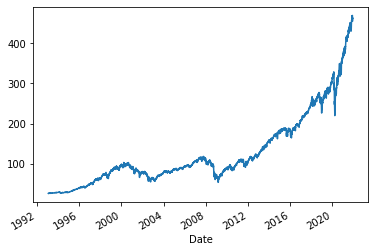

In [26]:
sp_df.day_mean.plot()
plt.show()

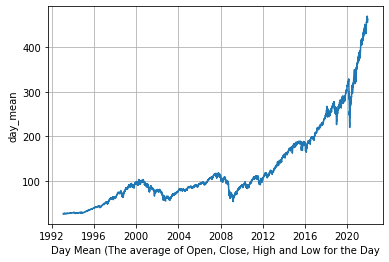

In [27]:
sns.lineplot(x=res_df.index, y=res_df.day_mean)
plt.grid()
plt.xlabel('Day Mean (The average of Open, Close, High and Low for the Day')
plt.show()

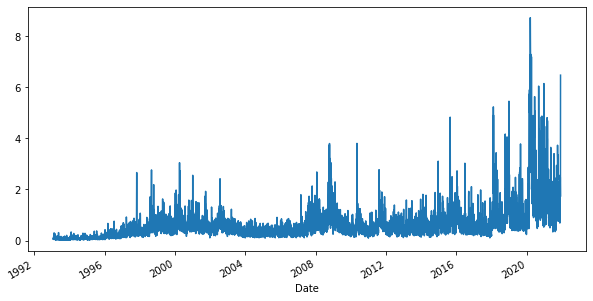

In [28]:
fig,ax = plt.subplots(figsize=(10,5))
sp_df.day_sd.plot()
plt.show()

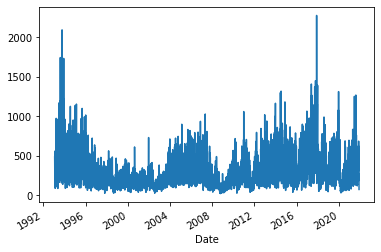

In [29]:
sp_df['cv'] = sp_df.day_mean/sp_df.day_sd
sp_df.cv.plot()
plt.show()

# Explore relationships between our features:

### Relationship between largest intraday gain and close label (Green 1, or Red 0)

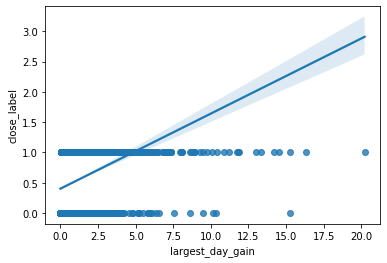

In [30]:
import seaborn as sns
sns.regplot(x='largest_day_gain', y='close_label', data=sp_df)
plt.show()

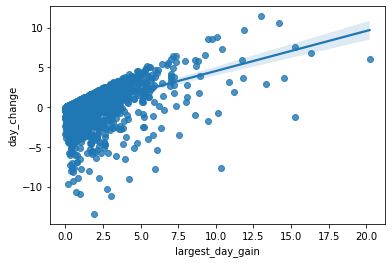

In [31]:
sns.regplot(x='largest_day_gain', y='day_change', data=sp_df)
plt.show()

### Relationship between largest intraday loss and close label and daily change

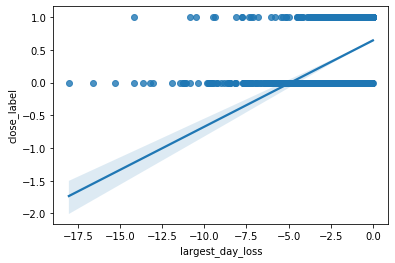

In [32]:
sns.regplot(x='largest_day_loss', y='close_label', data=sp_df)
plt.show()

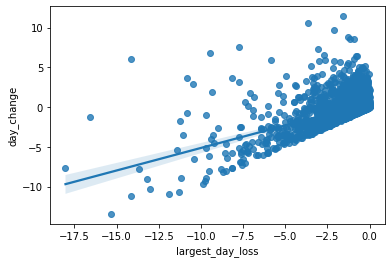

In [33]:
sns.regplot(x='largest_day_loss', y='day_change', data=sp_df)
plt.show()

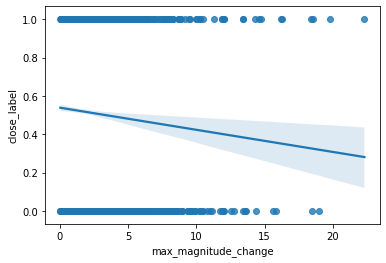

In [34]:
sns.regplot(x='max_magnitude_change', y='close_label', data=sp_df)
plt.show()

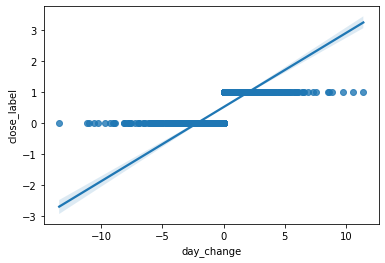

In [35]:
sns.regplot(x='day_change', y='close_label', data=sp_df)
plt.show()

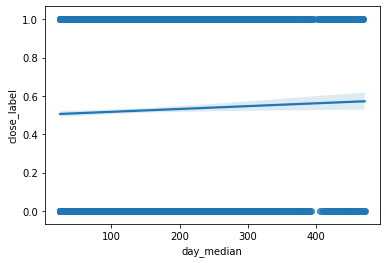

In [36]:
sns.regplot(x='day_median', y='close_label', data=sp_df)
plt.show()

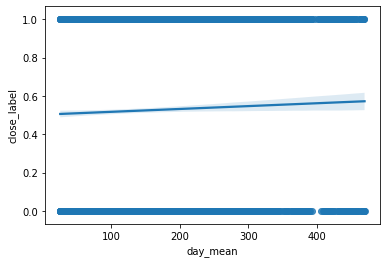

In [37]:
sns.regplot(x='day_mean', y='close_label', data=sp_df)
plt.show()

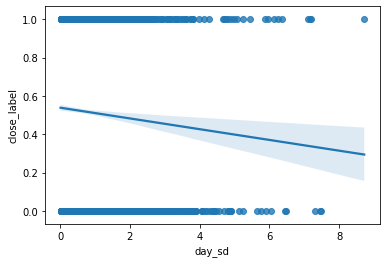

In [38]:
sns.regplot(x='day_sd', y='close_label', data=sp_df)
plt.show()

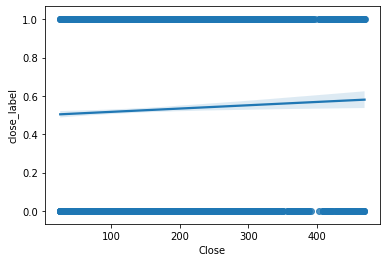

In [39]:
sns.regplot(x='Close', y='close_label', data=sp_df)
plt.show()

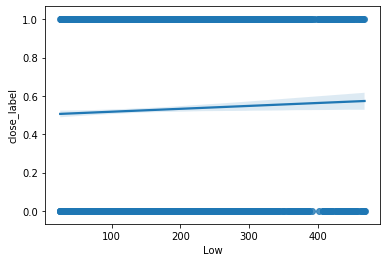

In [40]:
sns.regplot(x='Low', y='close_label', data=sp_df)
plt.show()

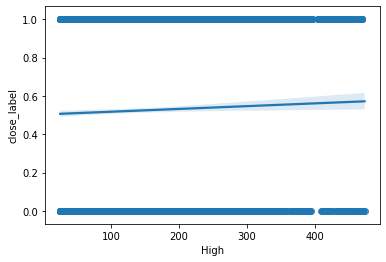

In [41]:
sns.regplot(x='High', y='close_label', data=sp_df)
plt.show()

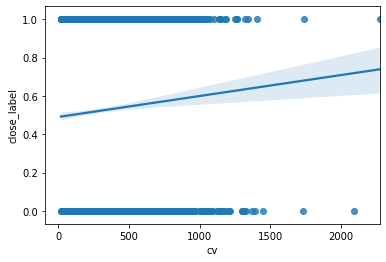

In [42]:
sns.regplot(x='cv', y='close_label', data=sp_df)
plt.show()

# Examine distributions of our features:

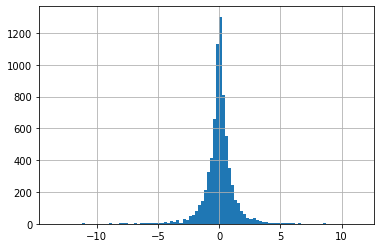

In [43]:
sp_df.day_change.hist(bins=100)
plt.show()

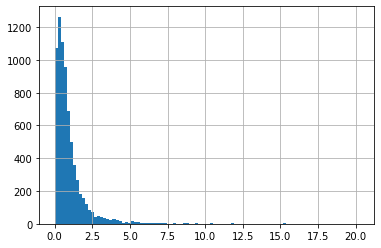

In [44]:
sp_df.largest_day_gain.hist(bins=100)
plt.show()

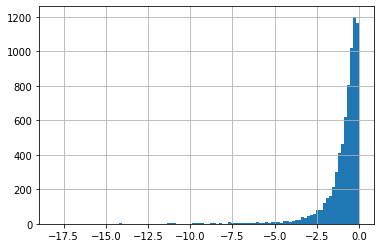

In [45]:
sp_df.largest_day_loss.hist(bins=100)
plt.show()

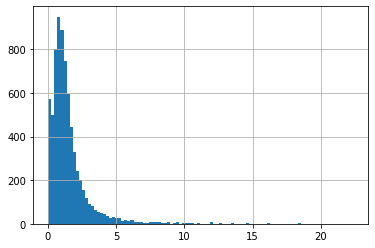

In [46]:
sp_df.max_magnitude_change.hist(bins=100)
plt.show()

# I'd really like intraday data to make better features:
    -percent time spent above open ; below close
    -num times cross open
    -etc

In [47]:
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,day_median,cv
Date,,,,,,,,,,,,,,
1993-01-29,25.735660,25.735660,25.607622,25.717369,1003200,-0.018291,0,0.128038,0.109747,-0.128038,0.053327,25.699078,25.671641,481.911024
1993-02-01,25.735667,25.900288,25.735667,25.900288,480500,0.164620,1,0.164620,0.164620,0.000000,0.082310,25.817977,25.817977,313.666667
1993-02-02,25.881988,25.973444,25.827114,25.955153,201300,0.073165,1,0.146329,0.128038,-0.054873,0.058560,25.909425,25.900279,442.440267
1993-02-03,25.991749,26.247825,25.973458,26.229534,529400,0.237785,1,0.274368,0.256076,-0.018291,0.128364,26.110642,26.110642,203.410328
1993-02-04,26.320984,26.394149,26.028326,26.339275,531500,0.018291,1,0.365823,0.310950,-0.292659,0.142492,26.270683,26.211237,184.365824


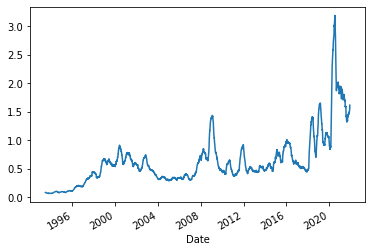

In [48]:
sp_df.rolling(window=100).day_sd.mean().plot()
plt.show()

# Let's try some modeling:

In [49]:
# day_sd, max magnitude change, largest day gain/loss, cv had strongest correlations

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [51]:
X = sp_df[['Open', 'High', 'Low', 'Close', 'max_magnitude_change', 
           'largest_day_gain', 'largest_day_loss', 'day_sd', 'cv']]
y = sp_df[['close_label']]
y = np.reshape(y.values, (len(X),))
y

array([0, 1, 1, ..., 1, 0, 0])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
rf_clf = RandomForestClassifier()

In [54]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [55]:
rf_clf.feature_importances_

array([0.01643164, 0.01418373, 0.01420811, 0.01609392, 0.06768975,
       0.36722003, 0.40025724, 0.08185901, 0.02205657])

## The largest day_loss, followed by the largest_day_gain were the most import features. Followed by day_sd. The other features had almost no predictive power :(

In [56]:
preds = rf_clf.predict(X_test)
preds

array([1, 0, 1, ..., 1, 0, 0])

In [57]:
y_test

array([1, 0, 1, ..., 1, 0, 0])

In [58]:
np.allclose(preds, y_test)

False

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(1109, 13, 25, 1251)

In [61]:
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

In [62]:
tpr

0.9804075235109718

In [63]:
fpr

0.011586452762923352

## I think my model is overfitting...

# 12/1/21:

# Let's try and form our baseline models. The DummyClassifier which randomly guesses the outcome with equal probability, the naive perma-bull and -bear, and the intelligent perma-bull and bear. 

In [64]:
res_df

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,day_median
Date,,,,,,,,,,,,,
1993-01-29,25.735660,25.735660,25.607622,25.717369,1003200,-0.018291,0,0.128038,0.109747,-0.128038,0.053327,25.699078,25.671641
1993-02-01,25.735667,25.900288,25.735667,25.900288,480500,0.164620,1,0.164620,0.164620,0.000000,0.082310,25.817977,25.817977
1993-02-02,25.881988,25.973444,25.827114,25.955153,201300,0.073165,1,0.146329,0.128038,-0.054873,0.058560,25.909425,25.900279
1993-02-03,25.991749,26.247825,25.973458,26.229534,529400,0.237785,1,0.274368,0.256076,-0.018291,0.128364,26.110642,26.110642
1993-02-04,26.320984,26.394149,26.028326,26.339275,531500,0.018291,1,0.365823,0.310950,-0.292659,0.142492,26.270683,26.211237
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,466.059998,469.570007,465.190002,469.440002,61858800,3.380005,1,4.380005,4.250000,-0.869995,1.964773,467.565002,467.380005
2021-11-26,462.339996,463.899994,457.769989,458.970001,112669600,-3.369995,0,6.130005,1.559998,-4.929993,2.474839,460.744995,460.834991
2021-11-29,464.070007,466.559998,461.730011,464.600006,86268800,0.529999,1,4.829987,2.869995,-2.339996,1.720533,464.240005,464.145004


In [65]:
y = res_df.close_label.values
y

array([0, 1, 1, ..., 1, 0, 0])

In [66]:
X = res_df.drop(columns='close_label').values
X

array([[2.57356602e+01, 2.57356602e+01, 2.56076221e+01, ...,
        5.33274331e-02, 2.56990779e+01, 2.56716412e+01],
       [2.57356672e+01, 2.59002876e+01, 2.57356672e+01, ...,
        8.23102361e-02, 2.58179774e+01, 2.58179774e+01],
       [2.58819879e+01, 2.59734437e+01, 2.58271144e+01, ...,
        5.85602770e-02, 2.59094246e+01, 2.59002790e+01],
       ...,
       [4.64070007e+02, 4.66559998e+02, 4.61730011e+02, ...,
        1.72053302e+00, 4.64240005e+02, 4.64145004e+02],
       [4.62000000e+02, 4.64029999e+02, 4.55299988e+02, ...,
        3.86091236e+00, 4.59222496e+02, 4.59664993e+02],
       [4.61640015e+02, 4.64670013e+02, 4.50290009e+02, ...,
        6.46974388e+00, 4.56775009e+02, 4.57480011e+02]])

In [67]:
#%%time
#sns.pairplot(data=res_df.drop(columns='close_label'))
#plt.show()

In [68]:
# lets scale the data
# it doesn't look like we have any standard guassians, so we should use
# max min scsler rather than the standard scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[7.39034002e-04, 5.71503035e-04, 1.23744592e-03, ...,
        4.61475339e-03, 6.27634918e-04, 6.37025516e-04],
       [7.39049531e-04, 9.38925337e-04, 1.52619909e-03, ...,
        7.94523453e-03, 8.95175030e-04, 9.65828903e-04],
       [1.06750322e-03, 1.10219805e-03, 1.73242095e-03, ...,
        5.21607162e-03, 1.10094383e-03, 1.15075279e-03],
       ...,
       [9.84690777e-01, 9.84421719e-01, 9.84733060e-01, ...,
        1.96197215e-01, 9.87404849e-01, 9.85844499e-01],
       [9.80044125e-01, 9.78775162e-01, 9.70232773e-01, ...,
        4.42153172e-01, 9.76114765e-01, 9.75778345e-01],
       [9.79236047e-01, 9.80203573e-01, 9.58934815e-01, ...,
        7.41940056e-01, 9.70607584e-01, 9.70868900e-01]])

In [69]:
# form train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
test_size=0.33, random_state=42)

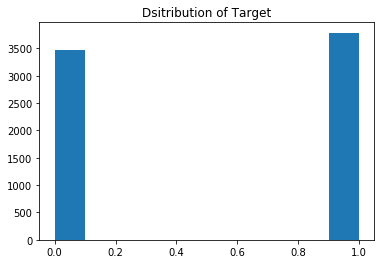

In [73]:
plt.hist(res_df.close_label.values)
plt.title('Dsitribution of Target')
plt.show()

Seems fairly balanced with slight lean towards positive closes. This is expected as markets tend to move upwards on average

In [70]:
from sklearn.dummy import DummyClassifier

In [81]:
# create one of 4 baseline models, the so called "random guesser"
# This agent will randomly guess market outcomes with equal probability
# I.e: votes in favor of "Green" or positive close vs "Red" or negative close, # both with equal probability, p=0.5
random_guesser = DummyClassifier(strategy='uniform', random_state=42)
random_guesser.fit(X_train, y_train)
print(random_guesser.predict(X_test))
print(random_guesser.score(X_test, y_test))

[0 1 0 ... 1 1 0]
0.4845704753961635


In [82]:
# first pass at this
# given classes are fairly balanced, I don't think this will perform
# as well as I think it could if we develop it futher
# (I was expecting a slightly larger class imbalance towards class 1)
intelligent_perma_bull = DummyClassifier(strategy='most_frequent', random_state=42)
intelligent_perma_bull.fit(X_train, y_train)
print(intelligent_perma_bull.predict(X_test))
print(intelligent_perma_bull.score(X_test, y_test))

[1 1 1 ... 1 1 1]
0.5321100917431193


### So our intelligent perma bull performs better than our random guesser (of equal probability). 
### This is a good start and we have a 53% (so more than 50%) chance of predicting the correct outcome!

In [77]:
#intelligent_perma_bear = ~intelligent_perma_bull.preds # invert predictions

In [83]:
perma_bull = DummyClassifier(strategy='constant', constant=1)
perma_bull.fit(X_train, y_train)
print(perma_bull.predict(X_test))
print(perma_bull.score(X_test, y_test))

[1 1 1 ... 1 1 1]
0.5321100917431193


## I find it hard to believe we would gat he EXACT same score... something is wrong

# OK so strategy='most_frequent' means it ALWAYS votes in favor of most prevalent class. Hence the same scores.

## TODO: figure out how to properly make an intelligent perma bull model which *usually* votes in favor of the most recent class.

In [84]:
perma_bear = DummyClassifier(strategy='constant', constant=0)
perma_bear.fit(X_train, y_train)
print(perma_bear.predict(X_test))
print(perma_bear.score(X_test, y_test))

[0 0 0 ... 0 0 0]
0.46788990825688076


## So far we have shown that being permnanetly bearish will lead to worst performance in terms of market close predictions.
## Randomly guessing is the next best. I'm surprised it is not closer to 50%? Maybe I have also misinterpreted how strategy'uniform' works. 


## Finally, our best baseline model, the perma-bull ahhieves a mean accuracy of 53%, which is at least better than flipping a fair coin (theoretically speaking).

# We think we can do better than this. IN particular, we need to improve (?) the random_guesser model, and properly develop the intelligent perma bull (and bear) models, which *usually* but not always vote in favor of the most prevalent class (and in the case of the bearish version, predicts the inverse class). Hint hint: exploitation-exploration paradigm from Reinforcement Learning and epsilong-greed search.

# Apart from building things like Logistic Regression , Random Forest, SVM, SGD, and KNN Classifiers, I would love to see you experiment with multi-armed bandits, etc.

Thus, apart from having trading strategies/routines (which may be rule-based and domain_informed), we'll have trading models, and finally can build proper trading bots which may employ some of these strategis and learn over time from their experience (failures and successes) in order to optimize performance.

In [72]:
from sklearn.metrics import confusion_matrix
